In [1]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

# Image Processing Libraries
import cv2
from cv2 import imread,resize
from scipy.ndimage import label, find_objects

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# File and Operating System Libraries
import os

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

# GPU Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
print(tf.config.list_physical_devices('GPU'))

# PATHS
IMG_PATH = 'data/image/'
MSK_PATH = 'data/mask/'

2024-11-24 15:13:17.150121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732482797.165510   14534 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732482797.170097   14534 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 15:13:17.189441: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
metadata = pd.read_csv('MetaData.csv')
metadata.info()
metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    object
 2   age      704 non-null    object
 3   county   704 non-null    object
 4   ptb      704 non-null    int64 
 5   remarks  699 non-null    object
dtypes: int64(2), object(4)
memory usage: 33.1+ KB


id gender age    county  ptb                                      remarks
0  1000   male  31  Shenxhen    0                                       normal
1  1001   male  64  Shenxhen    0                                       normal
2  1002   male  35  Shenxhen    0                                       normal
3  1003   male  32  Shenxhen    1               STB,ATB,tuberculosis pleuritis
4  1004   male   2  Shenxhen    1  secondary PTB  in the bilateral upper field

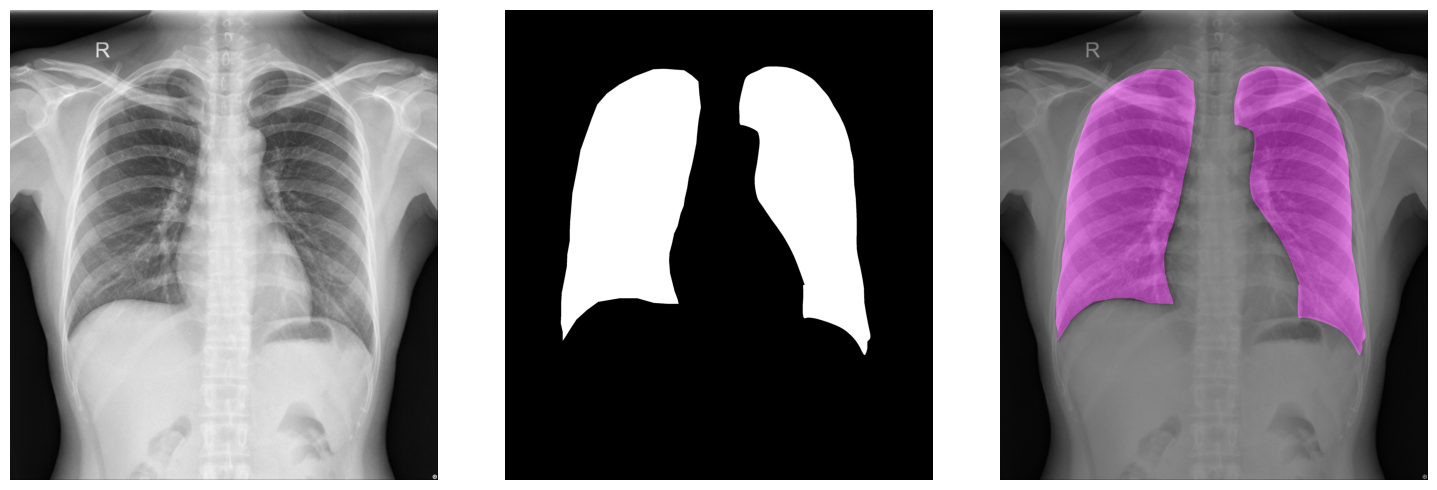

In [3]:
def get_colored_mask(image, mask_image,color = [255,20,255]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask!=[0,0,0])
    mask[mask_coord[0],mask_coord[1],:]= color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret
    
filenames = next(os.walk(IMG_PATH))[2][:1]
for file in filenames:
    img = imread(IMG_PATH+file)
    msk = imread(MSK_PATH+file)

    plt.figure(figsize=(15,5))

    plt.subplot(131)
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    
    plt.subplot(132)
    plt.imshow(msk,cmap='binary_r')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,msk))
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()

In [4]:
class DataGenerator(keras.utils.PyDataset):
    def __init__(self, img_files, mask_files, batch_size=32, size=(512, 512), seed=1, shuffle=True, **kwargs):
        """
        Custom data generator for segmentation tasks.
        
        Args:
        - img_dir: Directory containing the input images
        - mask_dir: Directory containing the corresponding masks
        - batch_size: Number of samples per batch
        - size: The target size for resizing the images and masks
        - seed: Random seed for reproducibility
        - shuffle: Whether to shuffle the dataset after each epoch
        """
        super().__init__(**kwargs)
        
        # List image and mask files
        self.img_filenames = img_files
        self.mask_filenames = mask_files
        
        self.batch_size = batch_size
        self.size = size
        self.seed = seed
        self.shuffle = shuffle
        
        # Ensure the number of images matches the number of masks
        assert len(self.img_filenames) == len(self.mask_filenames), \
            "The number of images and masks must be the same"
        
        self.indexes = np.arange(len(self.img_filenames))  # Indices for shuffling
        
        # If shuffle is enabled, shuffle the indices after each epoch
        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        """
        Returns the number of batches per epoch.
        """
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        """
        Generates a batch of data (images and corresponding masks).
        
        Args:
        - index: The index of the batch.
        
        Returns:
        - A batch of images and masks
        """
        # Get batch indices
        batch_indices = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        # Initialize empty arrays for the batch
        images = []  
        masks = []
        
        for i, idx in enumerate(batch_indices):
            # Load and preprocess image
            img = imread(IMG_PATH+self.img_filenames[idx],0)  # Read image
            img = resize(img, self.size)  # Resize to target size
            img = img / 255.0  # Normalize to [0, 1]
            
            # Load and preprocess mask
            mask = imread(MSK_PATH+self.mask_filenames[idx],0)  # Read mask 
            mask = resize(mask, self.size)  # Resize to target size
            # mask = cv2.dilate(mask, np.ones((15, 15), np.uint8), iterations=1)
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            mask = mask / 255.0  # Normalize to [0, 1]
            mask[mask > 0.5] = 1  # Binary mask
            
            # Add image and mask to the batch arrays
            images.append(img)
            masks.append(mask)
        
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset after each epoch.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

img_files, msk_files = sorted(os.listdir(IMG_PATH)), sorted(os.listdir(MSK_PATH))

train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(img_files,msk_files,test_size=0.3,random_state=1)

train_data = DataGenerator(
    img_files=train_img_files,        
    mask_files=train_msk_files,    
    batch_size=4,          
    size=(512, 512),
    workers=4, 
    use_multiprocessing=True
)

val_data = DataGenerator(
    img_files=val_img_files,        
    mask_files=val_msk_files,    
    batch_size=4,          
    size=(512, 512),
    workers=4,
    use_multiprocessing=True
)

In [5]:
def unet(input_shape, num_classes):
    # Input layer for the model
    inputs = layers.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    # First block with 64 filters
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)  # Add Batch Normalization
    pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)  # Downsample

    # Second block with 128 filters
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)  # Add Batch Normalization
    pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)  # Downsample

    # Third block with 256 filters
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)  # Add Batch Normalization
    pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)  # Downsample

    # Bottleneck layer with 512 filters
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)  # Add Batch Normalization

    # Expansive Path (Decoder)
    # First upsampling block
    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)  # Upsample
    merge6 = layers.concatenate([up6, conv3])  # Concatenate with the corresponding encoder block
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)  # Add Batch Normalization

    # Second upsampling block
    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)  # Upsample
    merge7 = layers.concatenate([up7, conv2])  # Concatenate with the corresponding encoder block
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)  # Add Batch Normalization

    # Third upsampling block
    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)  # Upsample
    merge8 = layers.concatenate([up8, conv1])  # Concatenate with the corresponding encoder block
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)  # Add Batch Normalization

    # Output layer for segmentation
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(conv8)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model  # Return the model

# Instantiate the model
input_shape = (512, 512, 1)  # Define the input shape for grayscale images
model = unet(input_shape, 1)  # Create U-Net model for binary segmentation

# Print the model summary
model.summary()  # Display model architecture


I0000 00:00:1732482841.057555   14534 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:25:00.0, compute capability: 8.0
I0000 00:00:1732482841.067154   14534 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79078 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:81:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 7,707,457 (29.40 MB)

 Trainable params: 7,701,825 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [6]:
# Jaccard Index Metric
def jaccard_index(y_true, y_pred, smooth=100):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection + smooth) / (total + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32
    
    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    # Calculate the Dice coefficient using the formula
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# Using the metrics in model compilation
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',dice_coefficient,jaccard_index])

In [7]:
## ModelCheckpoint: Save the model with the best validation loss during training
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_dice_coefficient',         # Metric to monitor 
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='max',                 # 'max' means the model with the highest metric score will be saved
    save_weights_only=False,     # Save the entire model (not just weights)
)

# Fit the model with multi-processing enabled
history = model.fit(
    train_data,                  # The training data generator or dataset
    validation_data=val_data,  # Validation data ratio 
    epochs=64,              # Number of epochs
    callbacks=[checkpoint],# Callbacks for checkpoint and early stopping
)

Epoch 1/64


I0000 00:00:1732482849.928107   14847 service.cc:148] XLA service 0x2aac88009fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732482849.928158   14847 service.cc:156]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
I0000 00:00:1732482849.928161   14847 service.cc:156]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-11-24 15:14:10.079740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732482850.841464   14847 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-24 15:14:29.518697: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compi

  2/123 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5338 - dice_coefficient: 0.4206 - jaccard_index: 0.2676 - loss: 0.8146 

I0000 00:00:1732482872.975052   14847 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8632 - dice_coefficient: 0.6645 - jaccard_index: 0.5053 - loss: 0.3594
Epoch 1: val_dice_coefficient improved from -inf to 0.40003, saving model to best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 62s 274ms/step - accuracy: 0.8635 - dice_coefficient: 0.6649 - jaccard_index: 0.5058 - loss: 0.3587 - val_accuracy: 0.2556 - val_dice_coefficient: 0.4000 - val_jaccard_index: 0.2508 - val_loss: 39.7716
Epoch 2/64
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9458 - dice_coefficient: 0.8272 - jaccard_index: 0.7078 - loss: 0.1520
Epoch 2: val_dice_coefficient did not improve from 0.40003
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.9458 - dice_coefficient: 0.8274 - jaccard_index: 0.7080 - loss: 0.1519 - val_accuracy: 0.7517 - val_dice_coefficient: 0.0082 - val_jaccard_index: 0.0045 - val_loss: 1.3642
Epoch 3/64
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9606 - dice_coefficient: 0.8783 - jaccard_index: 0.

Final Training Metrics:
Training Accuracy: 0.9946
Training Dice Coefficient: 0.9859
Training Jaccard Index: 0.9723
Training Loss: 0.0117

Final Validation Metrics:
Validation Accuracy: 0.9797
Validation Dice Coefficient: 0.9565
Validation Jaccard Index: 0.9170
Validation Loss: 0.1017


Text(0.5, 0, 'Epoch')

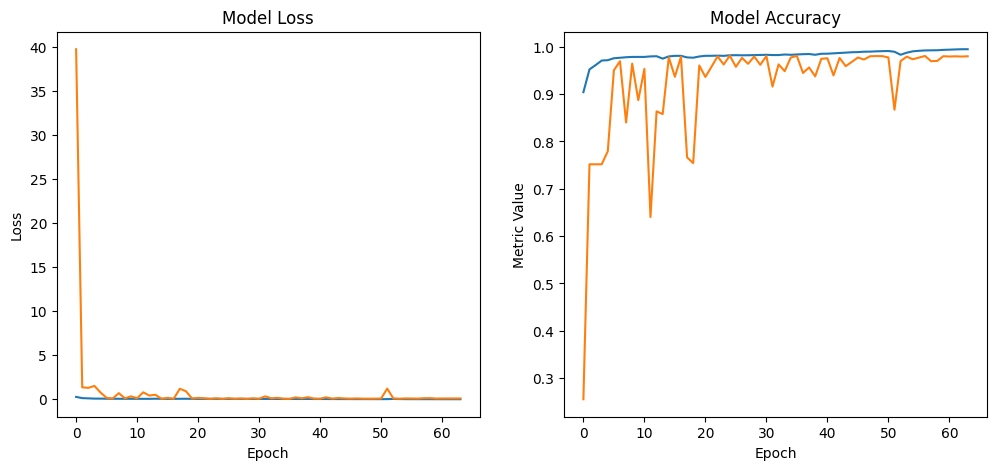

In [13]:
# Print final training metrics
print("Final Training Metrics:")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Training Dice Coefficient: {history.history['dice_coefficient'][-1]:.4f}")
print(f"Training Jaccard Index: {history.history['jaccard_index'][-1]:.4f}")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")

# Print final validation metrics
print("\nFinal Validation Metrics:")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Validation Dice Coefficient: {history.history['val_dice_coefficient'][-1]:.4f}")
print(f"Validation Jaccard Index: {history.history['val_jaccard_index'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")


# Plot training & validation loss values
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')



Testing model on variants (noisy, denoised, compressed)...


Processing images:   0%|          | 0/212 [00:00<?, ?it/s]

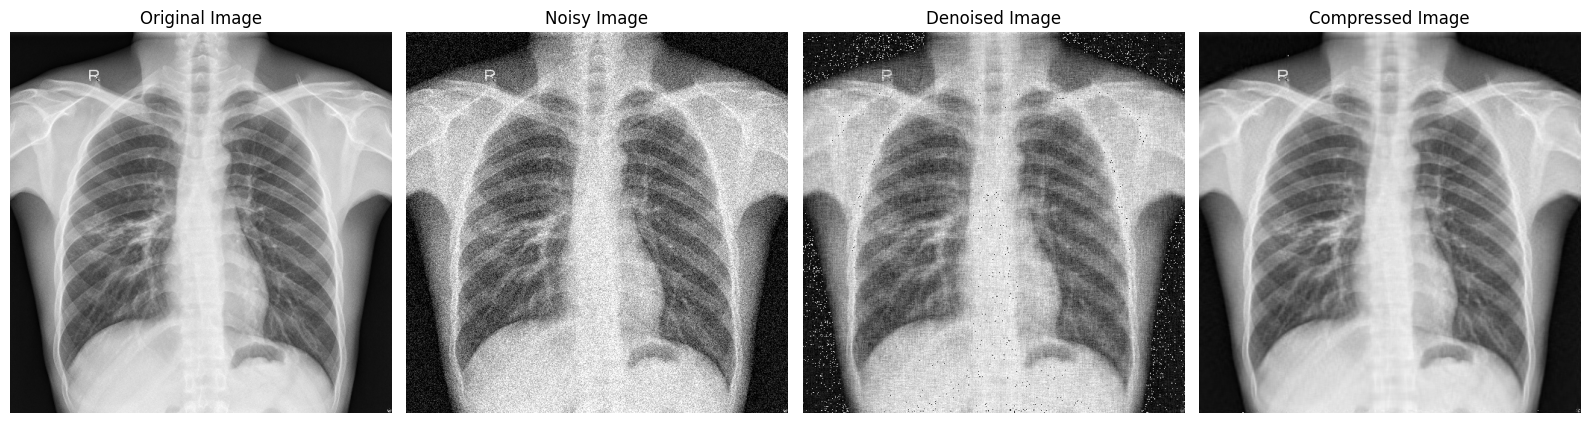

Processing images:   0%|          | 1/212 [00:00<03:25,  1.03it/s]

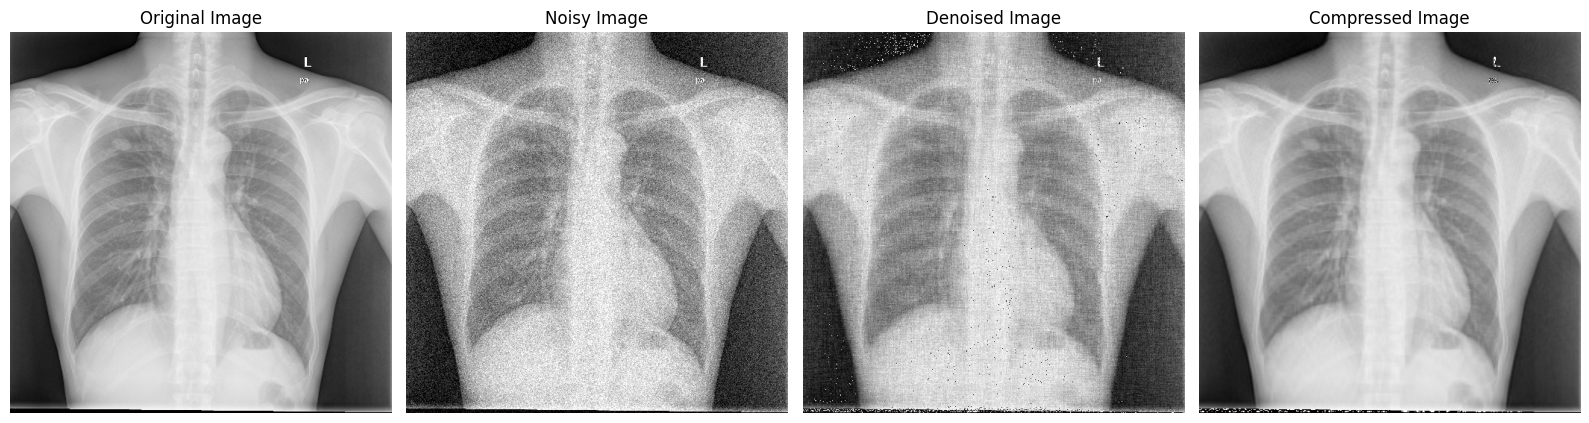

Processing images:   1%|          | 2/212 [00:01<03:26,  1.02it/s]

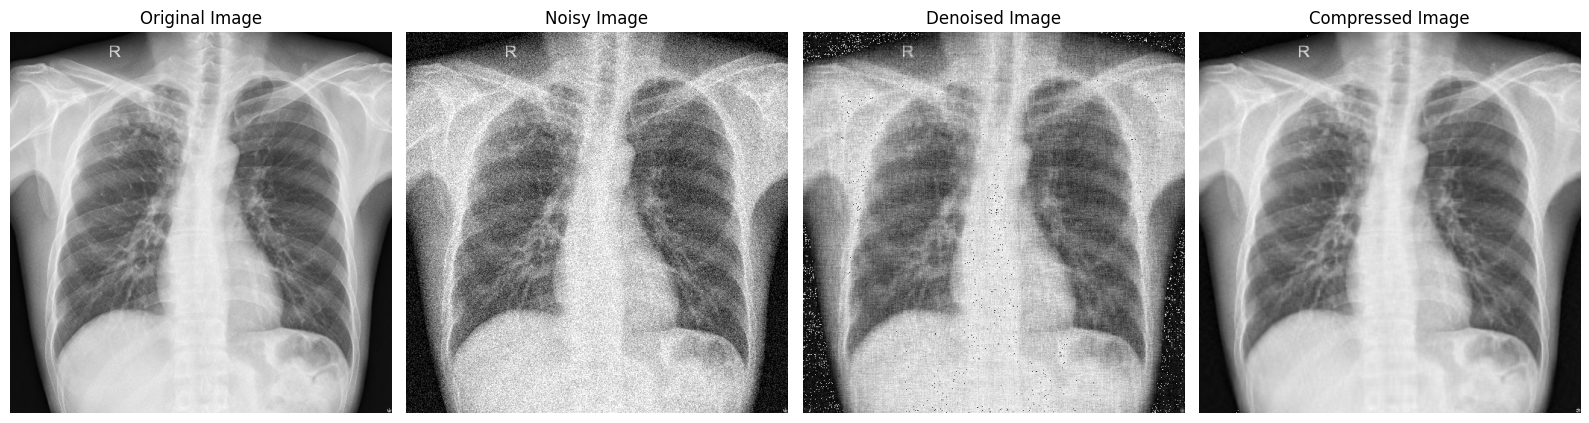

Processing images:   1%|▏         | 3/212 [00:02<03:24,  1.02it/s]

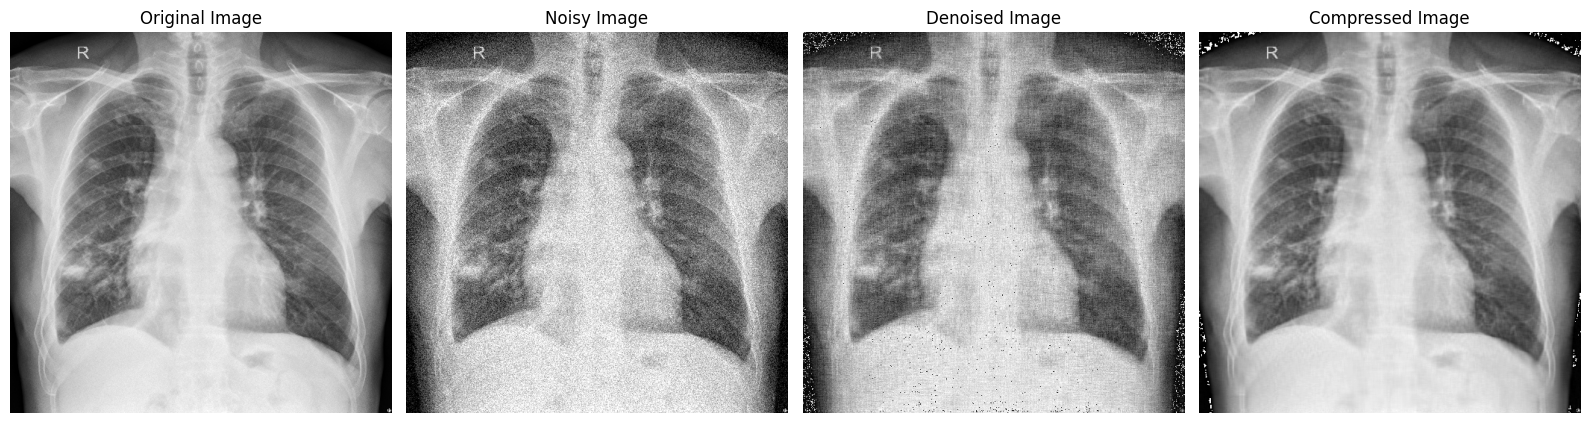

Processing images:   2%|▏         | 4/212 [00:03<03:23,  1.02it/s]

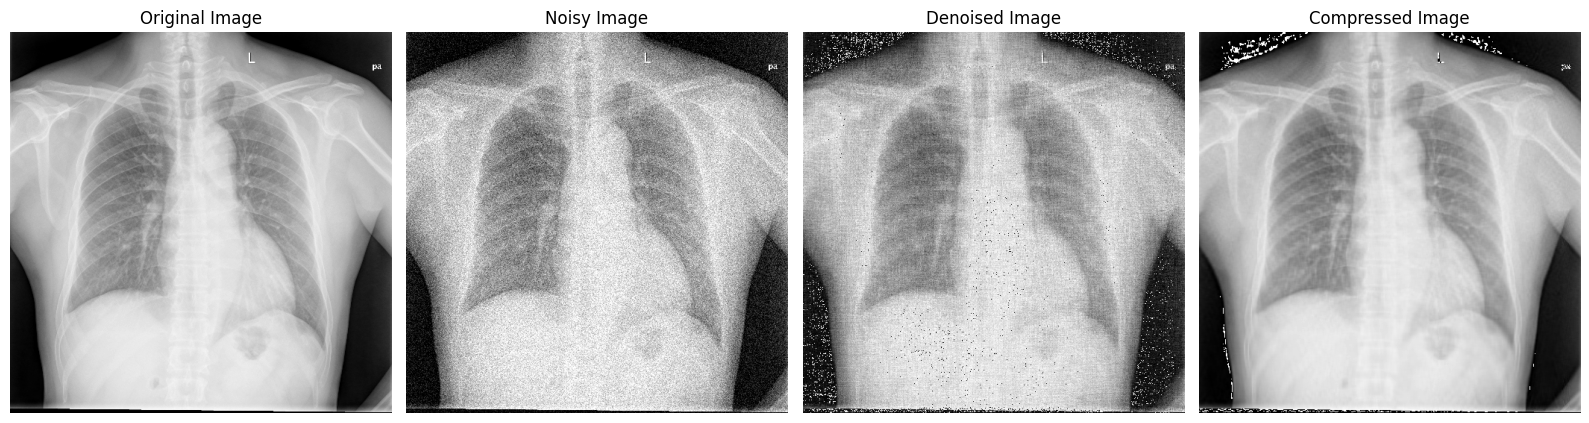

Processing images:   2%|▏         | 5/212 [00:04<03:23,  1.02it/s]

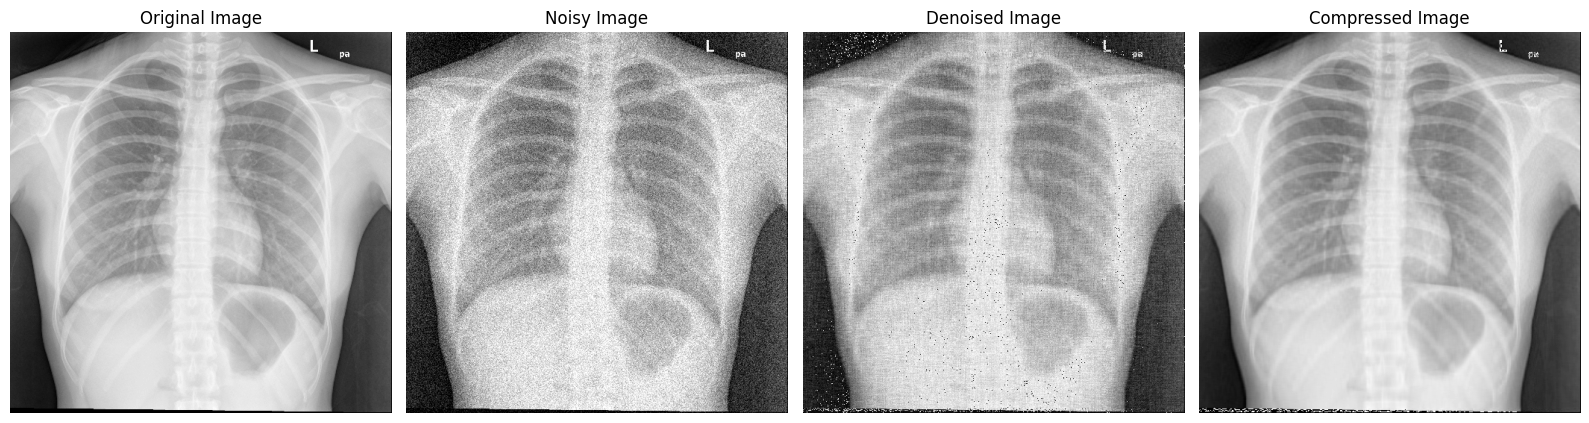

Processing images:   2%|▏         | 5/212 [00:05<04:05,  1.18s/it]


Testing completed!
Results:
Accuracy on Noisy Images: 0.5666
Accuracy on Denoised Images: 0.7643
Accuracy on Compressed Images: 0.9770


In [22]:
import random

# Add Noise to Images
def add_gaussian_noise(image, mean=0, std=25):
    """Adds Gaussian noise to an image."""
    noisy_image = image + np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(noisy_image, 0, 255)  # Clip to valid pixel range
    return noisy_image.astype(np.uint8)

def add_salt_pepper_noise(image, amount=0.02, salt_vs_pepper=0.5):
    """Adds salt-and-pepper noise to an image."""
    noisy_image = image.copy()
    num_salt = int(amount * image.size * salt_vs_pepper)
    num_pepper = int(amount * image.size * (1 - salt_vs_pepper))

    # Add Salt
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 255

    # Add Pepper
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image

# Denoise Images using SVD
def denoise_with_svd(image, k=50):
    """
    Denoise image using SVD by reconstructing it with top-k singular values.
    """
    # Perform SVD on each channel independently
    u, s, vt = np.linalg.svd(image, full_matrices=False)
    s[k:] = 0  # Zero out all but top-k singular values
    denoised_image = np.dot(u * s, vt)  # Reconstruct the image
    return denoised_image.astype(np.uint8)

# Compress Images using SVD
def compress_with_svd(image, k):
    """
    Compress an image using SVD by reconstructing it with top-k singular values.
    """
    u, s, vt = np.linalg.svd(image, full_matrices=False)
    s[k:] = 0  # Keep only the top-k singular values
    compressed_image = np.dot(u * s, vt)
    return compressed_image.astype(np.uint8)

def test_model_on_variants(model, img_files, mask_files, k=80):
    """
    Test the model on noisy, denoised, and compressed images with progress tracking and visualization.
    """
    results = {'noisy': [], 'denoised': [], 'compressed': []}

    print("Testing model on variants (noisy, denoised, compressed)...")

    # Loop through image files with progress tracking
    for idx, (img_file, mask_file) in tqdm(enumerate(zip(img_files, mask_files)), total=len(img_files), desc="Processing images"):
        # Load original image and mask
        img = imread(IMG_PATH + img_file, 0)  # Grayscale image
        mask = imread(MSK_PATH + mask_file, 0)  # Grayscale mask

        # Resize images and masks to the model's input size
        img = resize(img, (512, 512))  # Resize to model input shape
        mask = resize(mask, (512, 512))  # Resize to model input shape
        mask = mask / 255.0  # Normalize mask to [0, 1]

        # Add Gaussian noise
        noisy_img = add_gaussian_noise(img)
        noisy_img_resized = resize(noisy_img, (512, 512))  # Resize noisy image
        noisy_img_normalized = noisy_img_resized / 255.0  # Normalize to [0, 1]
        noisy_result = model.evaluate(noisy_img_normalized[None, ..., None], mask[None, ..., None], verbose=0)
        results['noisy'].append(noisy_result)

        # Denoise using SVD
        denoised_img = denoise_with_svd(noisy_img, k=k)  # Denoise with SVD
        denoised_img_resized = resize(denoised_img, (512, 512))  # Resize denoised image
        denoised_img_normalized = denoised_img_resized / 255.0  # Normalize to [0, 1]
        denoised_result = model.evaluate(denoised_img_normalized[None, ..., None], mask[None, ..., None], verbose=0)
        results['denoised'].append(denoised_result)

        # Compress using SVD
        compressed_img = compress_with_svd(img, k=k)  # Compress with SVD
        compressed_img_resized = resize(compressed_img, (512, 512))  # Resize compressed image
        compressed_img_normalized = compressed_img_resized / 255.0  # Normalize to [0, 1]
        compressed_result = model.evaluate(compressed_img_normalized[None, ..., None], mask[None, ..., None], verbose=0)
        results['compressed'].append(compressed_result)

        # Display the images
        plt.figure(figsize=(16, 8))
        plt.subplot(1, 4, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(noisy_img, cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(denoised_img, cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(compressed_img, cmap='gray')
        plt.title("Compressed Image")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Optional: Limit the number of images displayed (for testing)
        if idx >= 5:  # Display for the first 5 images only
            break

    print("\nTesting completed!")
    return results

# Call Testing Function
k_value = 70  # Set k as a hyperparameter
results = test_model_on_variants(model, val_img_files, val_msk_files, k=k_value)

# Print Results
print("Results:")
print(f"Accuracy on Noisy Images: {np.mean([r[1] for r in results['noisy']]):.4f}")
print(f"Accuracy on Denoised Images: {np.mean([r[1] for r in results['denoised']]):.4f}")
print(f"Accuracy on Compressed Images: {np.mean([r[1] for r in results['compressed']]):.4f}")


Evaluating images: 100%|██████████| 10/10 [07:27<00:00, 44.78s/it]


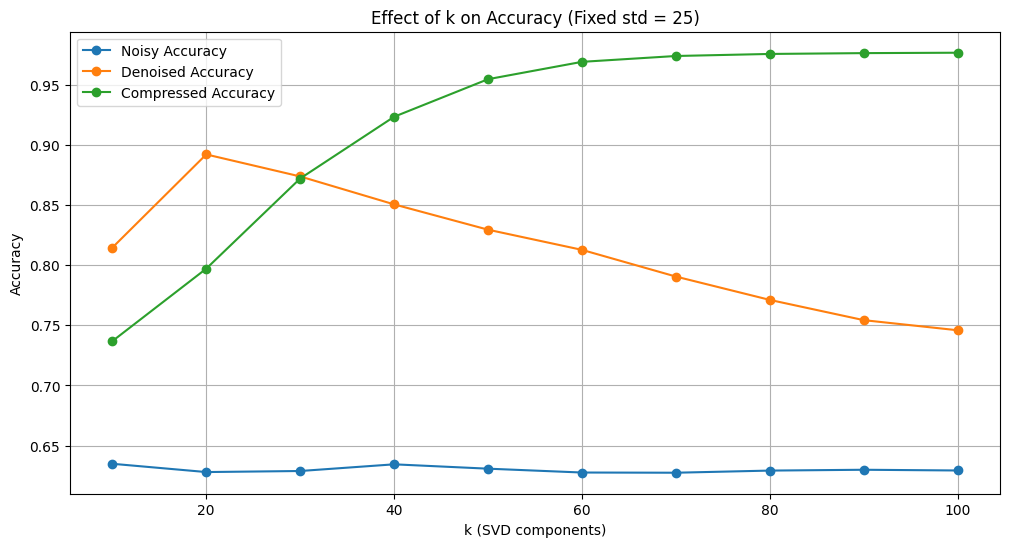

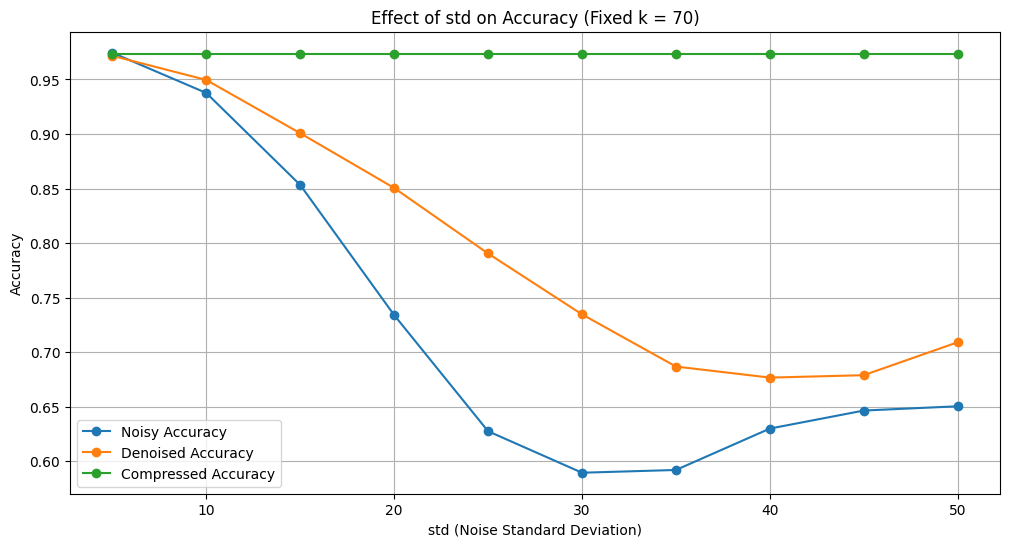

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Define the evaluation function
def evaluate_model_on_variants(model, image, mask, k_values, std_values):
    """
    Evaluate model accuracy on noisy, denoised, and compressed images.

    Parameters:
    - model: Trained model to evaluate
    - image: Original image
    - mask: Ground truth mask for evaluation
    - k_values: List of SVD components (k)
    - std_values: List of noise standard deviations (std)

    Returns:
    - Dictionary with accuracies for noisy, denoised, and compressed categories
    """
    results = {"noisy": [], "denoised": [], "compressed": []}

    for k in tqdm(k_values, desc="Processing k values"):
        for std in std_values:
            # Add Gaussian noise
            noisy_img = add_gaussian_noise(image, std=std)
            noisy_img = noisy_img / 255.0  # Normalize

            # Denoise using SVD
            denoised_img = denoise_with_svd(noisy_img * 255, k=k)
            denoised_img = denoised_img / 255.0  # Normalize

            # Compress using SVD
            compressed_img = compress_with_svd(image, k=k)
            compressed_img = compressed_img / 255.0  # Normalize

            # Evaluate model on each variant
            noisy_acc = model.evaluate(noisy_img[None, ..., None], mask[None, ..., None], verbose=0)[1]
            denoised_acc = model.evaluate(denoised_img[None, ..., None], mask[None, ..., None], verbose=0)[1]
            compressed_acc = model.evaluate(compressed_img[None, ..., None], mask[None, ..., None], verbose=0)[1]

            # Append results
            results["noisy"].append(noisy_acc)
            results["denoised"].append(denoised_acc)
            results["compressed"].append(compressed_acc)

    return results

# Define k and std values
k_values = np.arange(10, 110, 10)
std_values = np.arange(5, 55, 5)

# Select a random sample of images and masks
random_indices = random.sample(range(len(val_img_files)), 10)  # Adjust sample size if needed
selected_img_files = [val_img_files[i] for i in random_indices]
selected_msk_files = [val_msk_files[i] for i in random_indices]

# Initialize storage for results
noisy_acc, denoised_acc, compressed_acc = [], [], []

# Process each image
for img_file, msk_file in tqdm(zip(selected_img_files, selected_msk_files), total=len(selected_img_files), desc="Evaluating images"):
    # Load and preprocess the image and mask
    image = imread(IMG_PATH + img_file, 0)
    image = resize(image, (512, 512))  # Resize to input shape

    mask = imread(MSK_PATH + msk_file, 0)
    mask = resize(mask, (512, 512))  # Resize to input shape
    mask = mask / 255.0  # Normalize

    # Evaluate model on variants
    results = evaluate_model_on_variants(model, image, mask, k_values, std_values)

    # Store accuracy results
    noisy_acc.append(results["noisy"])
    denoised_acc.append(results["denoised"])
    compressed_acc.append(results["compressed"])

# Aggregate results across all images
noisy_acc = np.mean(noisy_acc, axis=0).reshape(len(k_values), len(std_values))
denoised_acc = np.mean(denoised_acc, axis=0).reshape(len(k_values), len(std_values))
compressed_acc = np.mean(compressed_acc, axis=0).reshape(len(k_values), len(std_values))

# Plot how k affects accuracy for all 3 categories
fixed_std = 25
std_index = list(std_values).index(fixed_std)

plt.figure(figsize=(12, 6))
plt.plot(k_values, noisy_acc[:, std_index], label="Noisy Accuracy", marker="o")
plt.plot(k_values, denoised_acc[:, std_index], label="Denoised Accuracy", marker="o")
plt.plot(k_values, compressed_acc[:, std_index], label="Compressed Accuracy", marker="o")
plt.title(f"Effect of k on Accuracy (Fixed std = {fixed_std})")
plt.xlabel("k (SVD components)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot how std affects accuracy for all 3 categories
fixed_k = 70
k_index = list(k_values).index(fixed_k)

plt.figure(figsize=(12, 6))
plt.plot(std_values, noisy_acc[k_index, :], label="Noisy Accuracy", marker="o")
plt.plot(std_values, denoised_acc[k_index, :], label="Denoised Accuracy", marker="o")
plt.plot(std_values, compressed_acc[k_index, :], label="Compressed Accuracy", marker="o")
plt.title(f"Effect of std on Accuracy (Fixed k = {fixed_k})")
plt.xlabel("std (Noise Standard Deviation)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


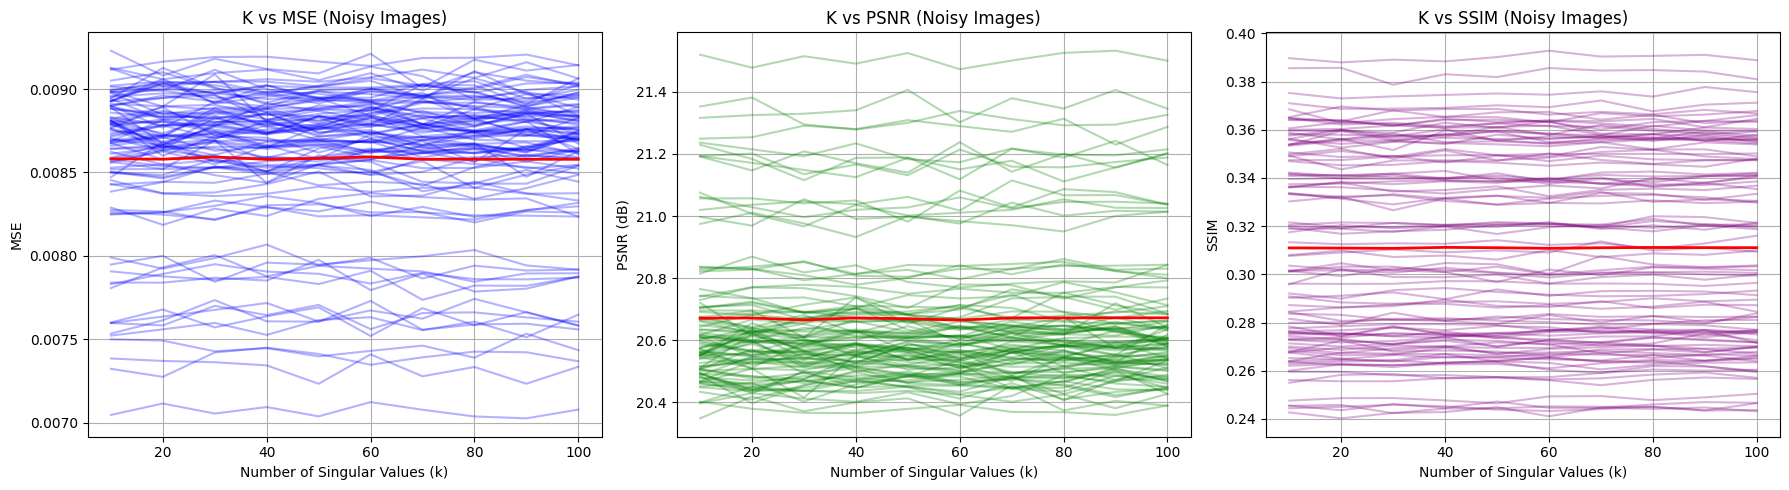

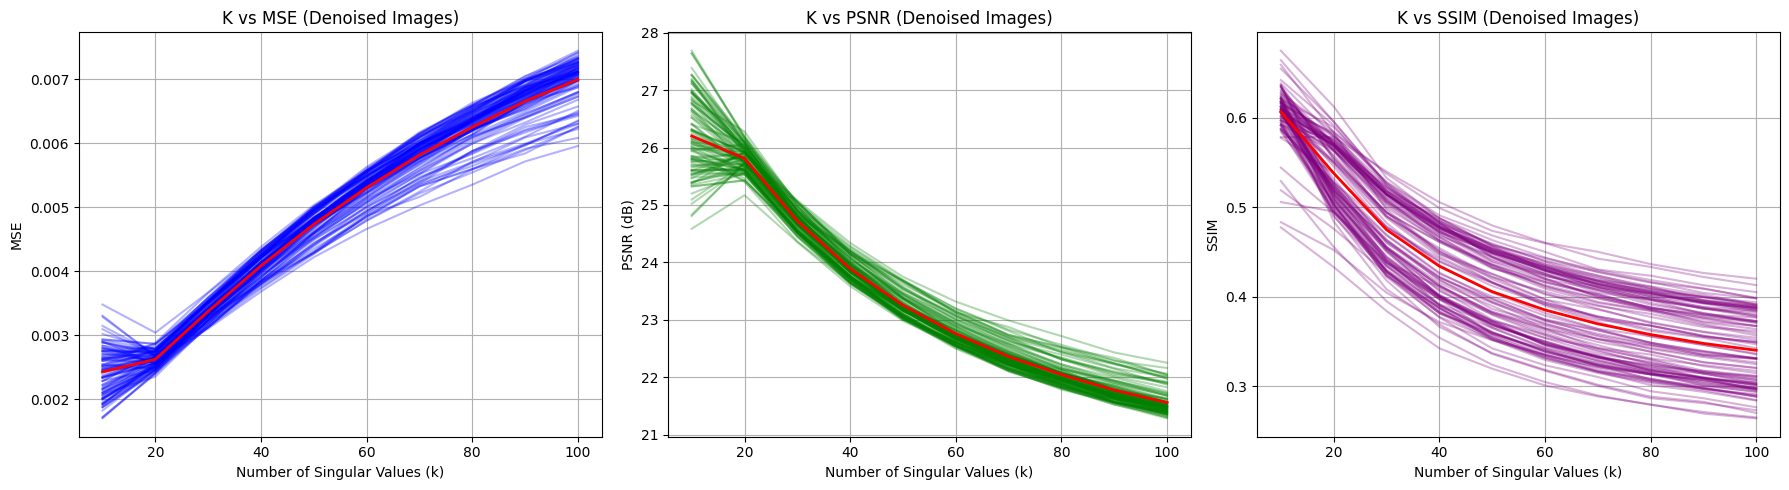

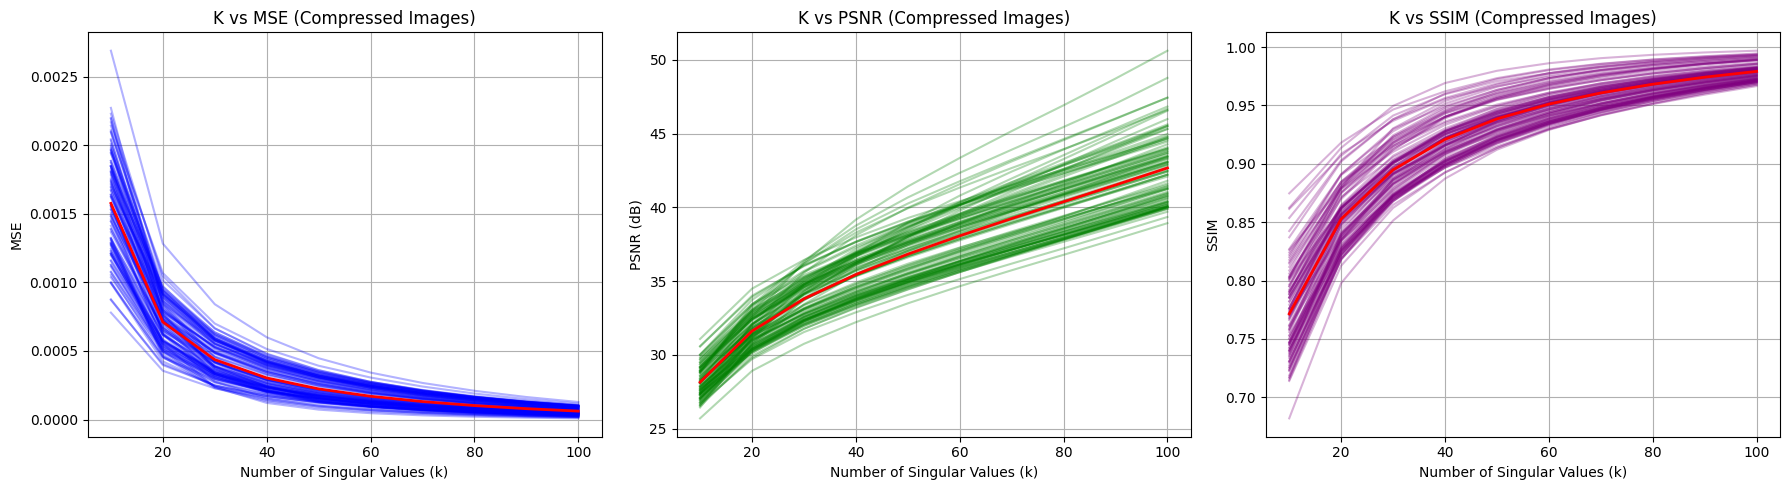

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from scipy.stats import linregress

# ---- Utility Functions ----

def load_images(folder_path, image_size=(128, 128), max_images=100, random_seed=None, normalize=False):
    """
    Load and resize a random subset of grayscale images from a folder.
    """
    if random_seed is not None:
        np.random.seed(random_seed)  # Set seed for reproducibility

    def process_image(file):
        img = cv2.imread(os.path.join(folder_path, file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)
            if normalize:
                img = img / 255.0  # Normalize to [0, 1]
            return img
        return None

    all_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    selected_files = np.random.choice(all_files, size=min(len(all_files), max_images), replace=False)

    images = []
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_image, selected_files)
        for img in results:
            if img is not None:
                images.append(img)

    return np.array(images)


def add_gaussian_noise(image, mean=0, std=25, normalize=False):
    """
    Adds Gaussian noise to an image.
    """
    if normalize:
        std /= 255.0
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1 if normalize else 255)
    return noisy_image


def apply_svd(image, k):
    """
    Applies SVD to truncate singular values and reconstruct the image.
    """
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    S_truncated = np.zeros_like(S)
    S_truncated[:k] = S[:k]  # Retain only the largest k singular values
    return np.dot(U, np.dot(np.diag(S_truncated), Vt))


def calculate_metrics(original, reconstructed, normalize=False):
    """
    Calculates MSE, PSNR, and SSIM between the original and reconstructed images.
    """
    mse = np.mean((original - reconstructed) ** 2)
    max_pixel = 1.0 if normalize else 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) if mse > 0 else 100
    ssim_value = ssim(original, reconstructed, data_range=max_pixel)
    return {"MSE": mse, "PSNR": psnr, "SSIM": ssim_value}


# ---- Plotting Functions ----

def plot_metrics(k_values, metrics, category_title):
    """
    Plots K vs MSE, PSNR, and SSIM for a single category.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # MSE Plot
    for mse in metrics["MSE"]:
        axes[0].plot(k_values, mse, alpha=0.3, color="blue")
    axes[0].plot(k_values, metrics["average_MSE"], label="Average MSE", color="red", linewidth=2)
    axes[0].set_title(f"K vs MSE ({category_title})")
    axes[0].set_xlabel("Number of Singular Values (k)")
    axes[0].set_ylabel("MSE")
    axes[0].grid(True)

    # PSNR Plot
    for psnr in metrics["PSNR"]:
        axes[1].plot(k_values, psnr, alpha=0.3, color="green")
    axes[1].plot(k_values, metrics["average_PSNR"], label="Average PSNR", color="red", linewidth=2)
    axes[1].set_title(f"K vs PSNR ({category_title})")
    axes[1].set_xlabel("Number of Singular Values (k)")
    axes[1].set_ylabel("PSNR (dB)")
    axes[1].grid(True)

    # SSIM Plot
    for ssim in metrics["SSIM"]:
        axes[2].plot(k_values, ssim, alpha=0.3, color="purple")
    axes[2].plot(k_values, metrics["average_SSIM"], label="Average SSIM", color="red", linewidth=2)
    axes[2].set_title(f"K vs SSIM ({category_title})")
    axes[2].set_xlabel("Number of Singular Values (k)")
    axes[2].set_ylabel("SSIM")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


# ---- Main Workflow ----

# Define parameters
image_folder_path = "data/image"
image_size = (256, 256)
max_images = 100
random_seed = 42
k_values = list(range(10, 101, 10))
std_dev = 25
normalize = True

# Load images
images = load_images(image_folder_path, image_size=image_size, max_images=max_images, random_seed=random_seed, normalize=normalize)

# Process categories
categories = ["Noisy Images", "Denoised Images", "Compressed Images"]
for category in categories:
    metrics = {"MSE": [], "PSNR": [], "SSIM": []}
    for k in k_values:
        mse_values, psnr_values, ssim_values = [], [], []
        for img in images:
            if category == "Noisy Images":
                noisy_img = add_gaussian_noise(img, std=std_dev, normalize=normalize)
                results = calculate_metrics(img, noisy_img, normalize=normalize)
            elif category == "Denoised Images":
                noisy_img = add_gaussian_noise(img, std=std_dev, normalize=normalize)
                denoised_img = apply_svd(noisy_img, k)
                results = calculate_metrics(img, denoised_img, normalize=normalize)
            else:  # Compressed Images
                compressed_img = apply_svd(img, k)
                results = calculate_metrics(img, compressed_img, normalize=normalize)

            mse_values.append(results["MSE"])
            psnr_values.append(results["PSNR"])
            ssim_values.append(results["SSIM"])

        metrics["MSE"].append(mse_values)
        metrics["PSNR"].append(psnr_values)
        metrics["SSIM"].append(ssim_values)

    metrics["MSE"] = np.array(metrics["MSE"]).T
    metrics["PSNR"] = np.array(metrics["PSNR"]).T
    metrics["SSIM"] = np.array(metrics["SSIM"]).T
    metrics["average_MSE"] = np.mean(metrics["MSE"], axis=0)
    metrics["average_PSNR"] = np.mean(metrics["PSNR"], axis=0)
    metrics["average_SSIM"] = np.mean(metrics["SSIM"], axis=0)

    plot_metrics(k_values, metrics, category)


In [35]:
import numpy as np
from tqdm import tqdm
import pandas as pd

# Initialize storage for PSNR, SSIM, and MSE values for noisy, denoised, and compressed images
psnr_noisy_values, ssim_noisy_values, mse_noisy_values = [], [], []
psnr_denoised_values, ssim_denoised_values, mse_denoised_values = [], [], []
psnr_compressed_values, ssim_compressed_values, mse_compressed_values = [], [], []

# Set fixed k and std values
fixed_k = 70
fixed_std = 25

# Assuming `images` is already loaded and contains 100 grayscale images
for img in tqdm(images, desc="Processing 100 images for k=70 and std=25"):
    # Generate noisy image
    noisy_img = add_gaussian_noise(img, std=fixed_std, normalize=normalize)

    # Denoised image using SVD
    denoised_img = apply_svd(noisy_img, k=fixed_k)

    # Compressed image using SVD
    compressed_img = apply_svd(img, k=fixed_k)

    # Calculate metrics for noisy image
    metrics_noisy = calculate_metrics(img, noisy_img, normalize=normalize)
    psnr_noisy_values.append(metrics_noisy["PSNR"])
    ssim_noisy_values.append(metrics_noisy["SSIM"])
    mse_noisy_values.append(metrics_noisy["MSE"])

    # Calculate metrics for denoised image
    metrics_denoised = calculate_metrics(img, denoised_img, normalize=normalize)
    psnr_denoised_values.append(metrics_denoised["PSNR"])
    ssim_denoised_values.append(metrics_denoised["SSIM"])
    mse_denoised_values.append(metrics_denoised["MSE"])

    # Calculate metrics for compressed image
    metrics_compressed = calculate_metrics(img, compressed_img, normalize=normalize)
    psnr_compressed_values.append(metrics_compressed["PSNR"])
    ssim_compressed_values.append(metrics_compressed["SSIM"])
    mse_compressed_values.append(metrics_compressed["MSE"])

# Calculate average metrics for each category
average_metrics = {
    "Noisy": {
        "Average PSNR (dB)": np.mean(psnr_noisy_values),
        "Average SSIM": np.mean(ssim_noisy_values),
        "Average MSE": np.mean(mse_noisy_values),
    },
    "Denoised": {
        "Average PSNR (dB)": np.mean(psnr_denoised_values),
        "Average SSIM": np.mean(ssim_denoised_values),
        "Average MSE": np.mean(mse_denoised_values),
    },
    "Compressed": {
        "Average PSNR (dB)": np.mean(psnr_compressed_values),
        "Average SSIM": np.mean(ssim_compressed_values),
        "Average MSE": np.mean(mse_compressed_values),
    },
}

# Convert average metrics into a DataFrame for better display
df = pd.DataFrame(average_metrics).T
df.index.name = "Category"
df.reset_index(inplace=True)

# Add proper column headers
df.columns = ["Category", "Average PSNR (dB)", "Average SSIM", "Average MSE"]

# Display the labeled table
print("Average PSNR, SSIM, and MSE for k=70 and std=25 for 100 images")
print(df)


Processing 100 images for k=70 and std=25: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]

Average PSNR, SSIM, and MSE for k=70 and std=25 for 100 images
     Category  Average PSNR (dB)  Average SSIM  Average MSE
0       Noisy          20.675116      0.217086     0.008580
1    Denoised          24.362778      0.349268     0.003665
2  Compressed          37.875662      0.925630     0.000179
